In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
%matplotlib inline
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
# 中文支持
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 


# <font color='blue' size=5> 一、理解数据

In [2]:
#导入数据
train=pd.read_csv("happiness_train_complete.csv",encoding='ISO-8859-1')
test=pd.read_csv("happiness_test_complete.csv",encoding='ISO-8859-1')
test_sub=pd.read_csv("happiness_submit.csv",encoding='ISO-8859-1')
print('训练集格式：',train.shape)
print('训练集格式：',test.shape)

训练集格式： (8000, 140)
训练集格式： (2968, 139)


In [3]:
#数据基础信息
train.describe()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,6880.000000,6028.000000,8.000000e+03,8000.000000,824.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,7996.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,7204.000000,7204.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,2951.000000,2951.000000,2951.000000,2951.000000,8000.000000,8000.000000,8000.000000,8000.000000,7.999000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,6934.000000,8000.000000,7172.000000,6282.000000,6230.000000,6282.000000,6282.000000,6282.000000,6.282000e+03,6282.000000,2565.000000,2565.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000
mean,4000.50000,3.850125,1.405500,15.155375,42.564750,70.619000,1.53000,1964.707625,1.37350,0.772250,1.427250,4.878375,3.505523,1574.742867,3.330734e+04,1.317750,1785.067961,115.302954,0.007875,0.473000,0.268500,0.101125,0.102750,0.023625,0.004000,0.022500,0.13600,163.989750,121.575625,3.598500,3.786250,3.819375,1.893750,1.375938,1.891875,1.710125,1.797375,3.915375,2.368625,1.60575,1.625250,4.496500,3.452375,3.762125,4.402625,3.756250,3.554000,3.591500,3.521500,4.713500,4.482125,3.427375,2.790625,3.291000,1.92650,3.474181,3.622432,1.825500,3.135125,4.192250,3.439625,4.445125,2.925375,2.979750,3.155202,14.500508,0.906811,2.652321,1.062125,1.232875,1.820875,1.835625,6.776050e+04,2.882500,2.595875,1.063625,1.817125,0.014875,0.909500,0.06150,0.020750,0.004750,0.001875,0.0,0.000750,0.000750,0.924375,0.767125,0.456879,3.234375,1825.481177,1963.963069,1868.025522,4.614454,1.319007,1.842566,2.836550e+04,2.838427,3.175828,0.963743,1108.42025,2.043500,1.079125,2.744625,1150.667250,1.550500,0.89900

In [4]:
col = train.columns.tolist()
print('数据特征及标签：',col)

数据特征及标签： ['id', 'happiness', 'survey_type', 'province', 'city', 'county', 'survey_time', 'gender', 'birth', 'nationality', 'religion', 'religion_freq', 'edu', 'edu_other', 'edu_status', 'edu_yr', 'income', 'political', 'join_party', 'floor_area', 'property_0', 'property_1', 'property_2', 'property_3', 'property_4', 'property_5', 'property_6', 'property_7', 'property_8', 'property_other', 'height_cm', 'weight_jin', 'health', 'health_problem', 'depression', 'hukou', 'hukou_loc', 'media_1', 'media_2', 'media_3', 'media_4', 'media_5', 'media_6', 'leisure_1', 'leisure_2', 'leisure_3', 'leisure_4', 'leisure_5', 'leisure_6', 'leisure_7', 'leisure_8', 'leisure_9', 'leisure_10', 'leisure_11', 'leisure_12', 'socialize', 'relax', 'learn', 'social_neighbor', 'social_friend', 'socia_outing', 'equity', 'class', 'class_10_before', 'class_10_after', 'class_14', 'work_exper', 'work_status', 'work_yr', 'work_type', 'work_manage', 'insur_1', 'insur_2', 'insur_3', 'insur_4', 'family_income', 'family_m', '

In [5]:
train.head(5)

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


In [6]:
#训练集数据缺失程度
train.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 140 columns):
id                      8000 non-null int64
happiness               8000 non-null int64
survey_type             8000 non-null int64
province                8000 non-null int64
city                    8000 non-null int64
county                  8000 non-null int64
survey_time             8000 non-null object
gender                  8000 non-null int64
birth                   8000 non-null int64
nationality             8000 non-null int64
religion                8000 non-null int64
religion_freq           8000 non-null int64
edu                     8000 non-null int64
edu_other               3 non-null object
edu_status              6880 non-null float64
edu_yr                  6028 non-null float64
income                  8000 non-null int64
political               8000 non-null int64
join_party              824 non-null float64
floor_area              8000 non-null float64
proper

In [7]:
#测试集数据缺失程度
test.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 139 columns):
id                      2968 non-null int64
survey_type             2968 non-null int64
province                2968 non-null int64
city                    2968 non-null int64
county                  2968 non-null int64
survey_time             2968 non-null object
gender                  2968 non-null int64
birth                   2968 non-null int64
nationality             2968 non-null int64
religion                2968 non-null int64
religion_freq           2968 non-null int64
edu                     2968 non-null int64
edu_other               3 non-null object
edu_status              2519 non-null float64
edu_yr                  2184 non-null float64
income                  2968 non-null int64
political               2968 non-null int64
join_party              302 non-null float64
floor_area              2968 non-null float64
property_0              2968 non-null int64
proper

# <font color='blue' size=5> 二、数据清洗

In [8]:
#处理标签
y_train_=train["happiness"]
print('标签数据分布:\n',y_train_.value_counts())
#将-8转换为3
train['happiness'] = train['happiness'].map(lambda x: 3 if x==-8 else x)
#将标签修改为0开始
train['happiness'] = train['happiness'].map(lambda x:x-1)
y_train_ = train['happiness']
print('处理后的标签数据分布:\n',y_train_.value_counts())

标签数据分布:
  4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64
处理后的标签数据分布:
 3    4818
4    1410
2    1171
1     497
0     104
Name: happiness, dtype: int64


In [9]:
#train和test连在一起
data = pd.concat([train,test],axis=0,ignore_index=True)
print('数据大小：',data.shape)

数据大小： (10968, 140)


E:\python\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [10]:
#处理数据类型
#处理时间特征
data['survey_time'] = pd.to_datetime(data['survey_time'],format='%Y-%m-%d %H:%M:%S')
data["weekday"]=data["survey_time"].dt.weekday
data["year"]=data["survey_time"].dt.year
data["quarter"]=data["survey_time"].dt.quarter
data["hour"]=data["survey_time"].dt.hour
data["month"]=data["survey_time"].dt.month

In [11]:
#填充数据
data["edu_status"]=data["edu_status"].fillna(5)
data["edu_yr"]=data["edu_yr"].fillna(-2)
data["property_other"]=data["property_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["hukou_loc"]=data["hukou_loc"].fillna(1)
data["social_neighbor"]=data["social_neighbor"].fillna(8)
data["social_friend"]=data["social_friend"].fillna(8)
data["work_status"]=data["work_status"].fillna(0)
data["work_yr"]=data["work_yr"].fillna(0)
data["work_type"]=data["work_type"].fillna(0)
data["work_manage"]=data["work_manage"].fillna(0)
data["family_income"]=data["family_income"].fillna(-2)
data["invest_other"]=data["invest_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["minor_child"]=data["minor_child"].fillna(0)
data["marital_1st"]=data["marital_1st"].fillna(0)
data["s_birth"]=data["s_birth"].fillna(0)
data["marital_now"]=data["marital_now"].fillna(0)
data["s_edu"]=data["s_edu"].fillna(0)
data["s_political"]=data["s_political"].fillna(0)
data["s_hukou"]=data["s_hukou"].fillna(0)
data["s_income"]=data["s_income"].fillna(0)
data["s_work_exper"]=data["s_work_exper"].fillna(0)
data["s_work_status"]=data["s_work_status"].fillna(0)
data["s_work_type"]=data["s_work_type"].fillna(0)
#去掉缺失值很多的
data=data.drop(['edu_other'], axis=1)

# <font color='blue' size=5> 三、特征工程

In [12]:
#把一天的时间分段
def hour_cut(x):
    if 0<=x<6:
        return 0
    elif  6<=x<8:
        return 1
    elif  8<=x<12:
        return 2
    elif  12<=x<14:
        return 3
    elif  14<=x<18:
        return 4
    elif  18<=x<21:
        return 5
    elif  21<=x<24:
        return 6

data["hour_cut"]=data["hour"].map(hour_cut)

In [13]:
#是否入党
data["join_party"]=data["join_party"].map(lambda x:0 if pd.isnull(x)  else 1)
#做问卷时候的年龄
data["survey_age"]=data["year"]-data["birth"]

In [14]:
#出生的年代
def birth_split(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7
    
data["birth_s"]=data["birth"].map(birth_split)

In [15]:
#收入分组
def income_cut(x):
    if x<=0:
        return 0
    elif  0<x<=1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<=24000:
        return 3
    elif  24000<x<=40000:
        return 4
    elif  40000<x:
        return 5
 
data["income_cut"]=data["income"].map(income_cut)

In [16]:
data.isnull().sum(axis=0)

birth                      0
car                        0
city                       0
class                      0
class_10_after             0
class_10_before            0
class_14                   0
county                     0
daughter                   0
depression                 0
edu                        0
edu_status                 0
edu_yr                     0
equity                     0
f_birth                    0
f_edu                      0
f_political                0
f_work_14                  0
family_income              0
family_m                   0
family_status              0
floor_area                 0
gender                     0
happiness               2968
health                     0
health_problem             0
height_cm                  0
house                      0
hukou                      0
hukou_loc                  0
id                         0
inc_ability                0
inc_exp                    0
income                     0
insur_1       

# <font color='blue' size=5> 四、数据可视化

In [25]:
#提取可视化数据
data_show = data.copy().iloc[:train.shape[0]]

## <font color='gray' size=4> 4.1 标签分布

Text(0.5, 1.0, 'happiness')

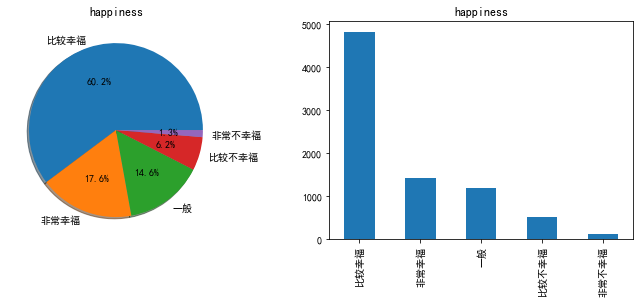

In [26]:
#查看标签分布情况
dict_y = {0:'非常不幸福',1:'比较不幸福',2:'一般',3:'比较幸福',4:'非常幸福'}
y_train_dict = y_train_.map(dict_y)

fig,ax = plt.subplots(1,2,figsize=(12,4))
y_train_dict.value_counts().plot.pie(autopct='%1.1f%%',shadow=True,ax=ax[0])
ax[0].set_title('happiness')
ax[0].set_ylabel('')
y_train_dict.value_counts().plot.bar()
ax[1].set_title('happiness')
#{0:非常不幸福,1:比较不幸福,2:一般,3:比较幸福,4:很幸福}

居民普遍为中等幸福感，低幸福感的人数较少

## <font color='gray' size=4> 4.2 性别和幸福感的关系

Text(0, 0.5, 'gender')

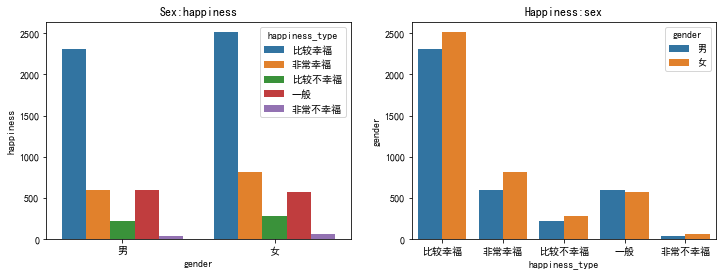

In [27]:
# 探究性别和幸福感的关系
def transf_gender(x):
    if x == 1:
        return '男'
    elif x == 2:
        return '女'
data_show['gender'] = data_show['gender'].map(transf_gender)
data_show['happiness_type'] = data_show['happiness'].map(dict_y)

fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.countplot('gender',hue='happiness_type',data=data_show,ax=ax[0])
ax[0].set_title('Sex:happiness')
ax[0].set_ylabel('happiness')
sns.countplot('happiness_type',hue='gender',data=data_show,ax=ax[1])
ax[1].set_title('Happiness:sex')
ax[1].set_ylabel('gender')

男女幸福指数并没有较大的差异

## <font color='gray' size=4> 4.3 地区和幸福感的关系

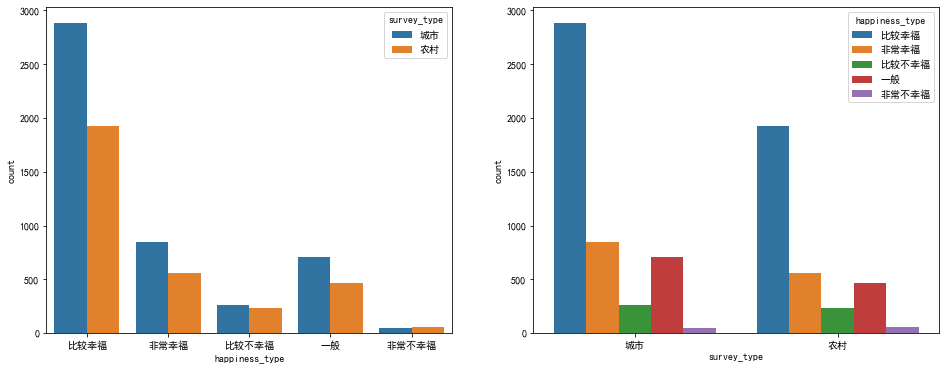

In [28]:
dict_type={1:'城市',2:'农村'}
data_show['survey_type'] = data_show['survey_type'].map(dict_type)
fig,ax = plt.subplots(1,2,figsize=(16,6))
sns.countplot('happiness_type',hue='survey_type',data=data_show,ax=ax[0])
sns.countplot('survey_type',hue='happiness_type',data=data_show,ax=ax[1])

城市居民相比于农村居民的幸福感更高，但都存在一部分幸福感较低的居民

In [29]:
dict_pro = {1:'上海市',2:'云南省',3:'内蒙古自治区',4:'北京市',5:'吉林省',6:'四川省',7:'天津市',8 : '宁夏回族自治区',
           9: '安徽省',10:'山东省',11 :'山西省',12 :'广东省',13:'广西壮族自治区',14: '新疆维吾尔自治区',15:'江苏省',16:'江西省',
           17:'河北省',18 :'河南省', 19:'浙江省',20 :'海南省',21:'湖北省', 22 :'湖南省',23:'甘肃省',24: '福建省', 25:'西藏自治区',
           26:'贵州省', 27:'辽宁省', 28:'重庆市', 29:'陕西省', 30:'青海省',31:'黑龙江省'}
pro = data_show['province'].unique().tolist()
print('数据来源于%d个省'%len(pro))

数据来源于28个省


E:\python\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
E:\python\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
E:\python\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retain

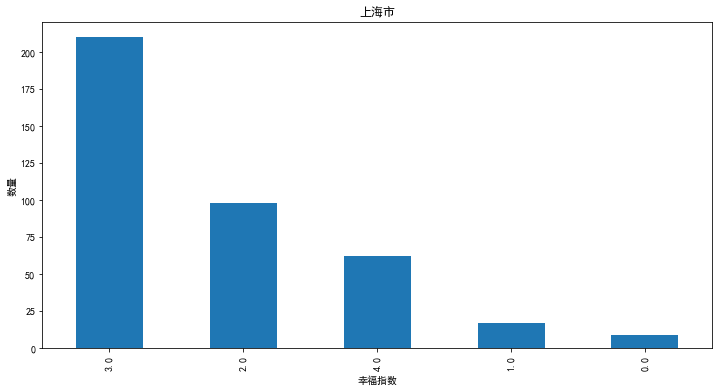

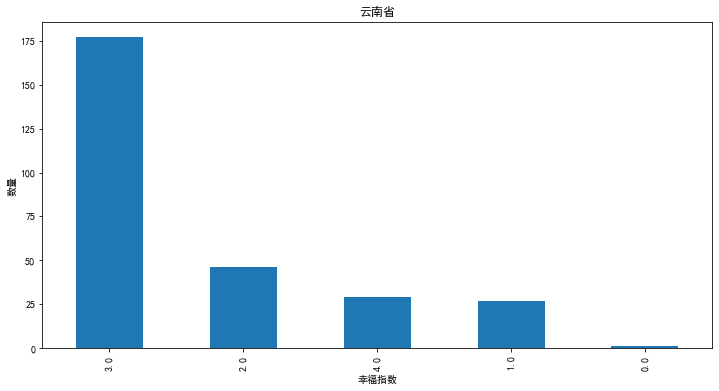

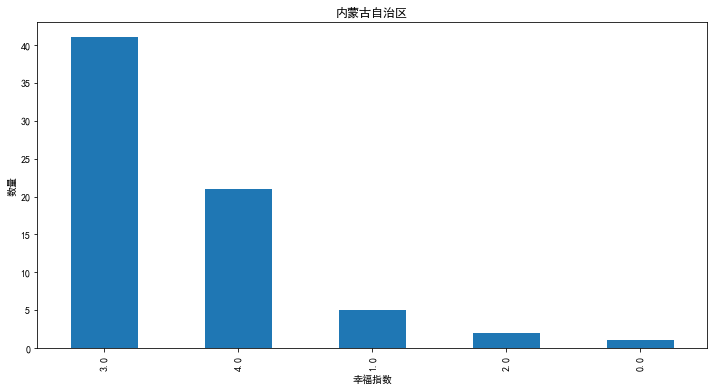

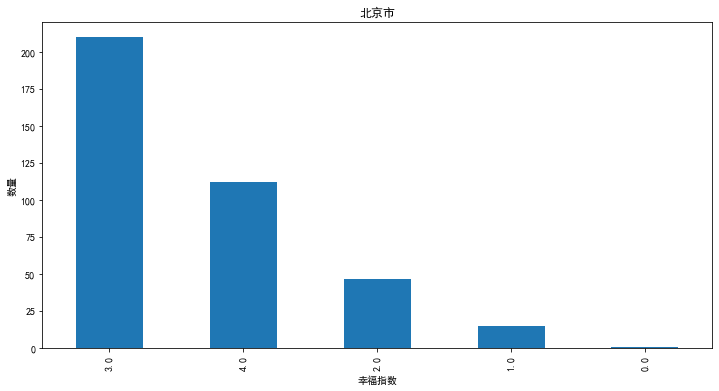

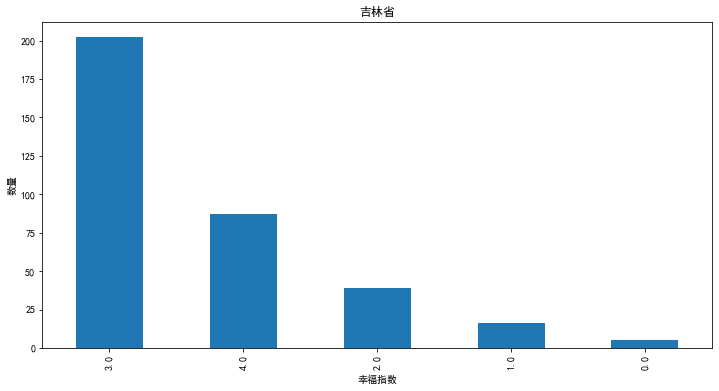

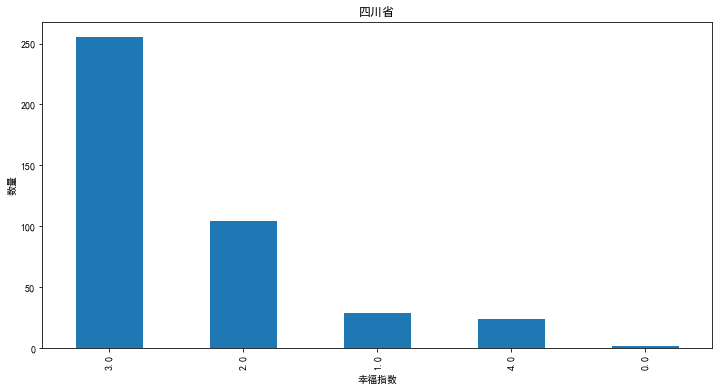

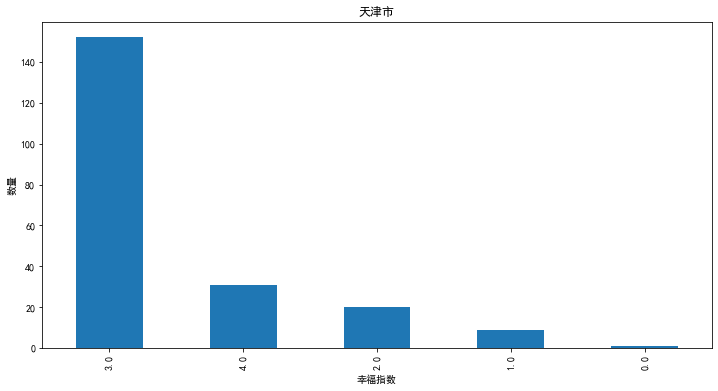

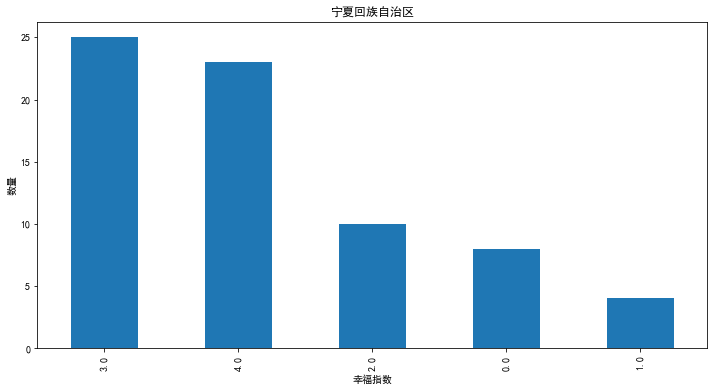

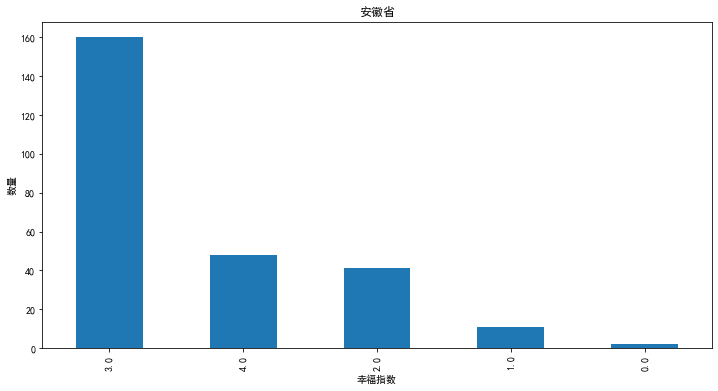

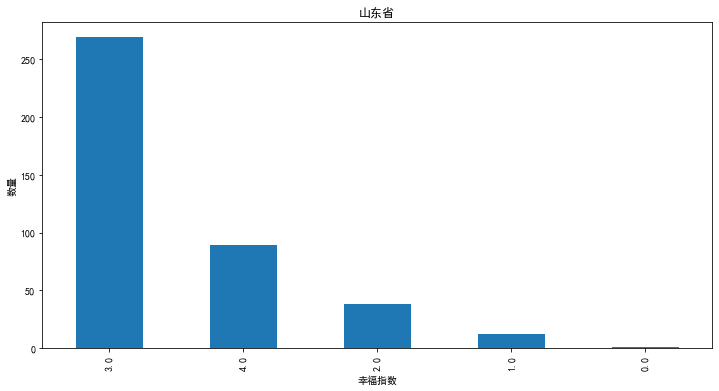

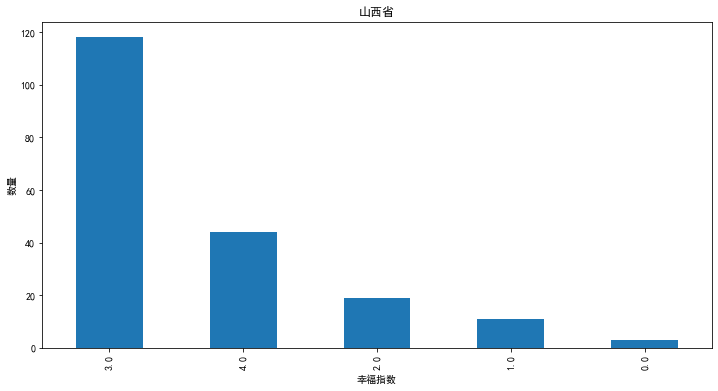

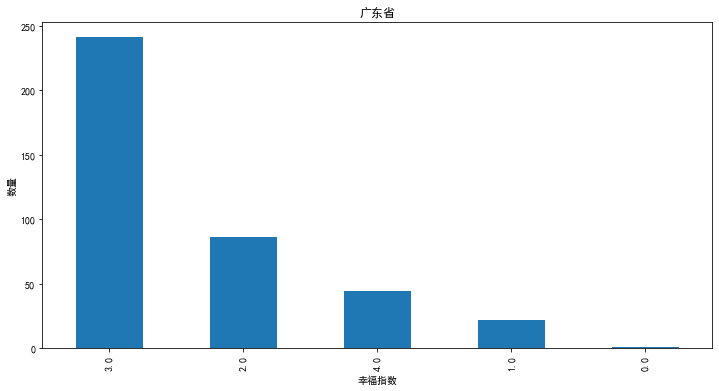

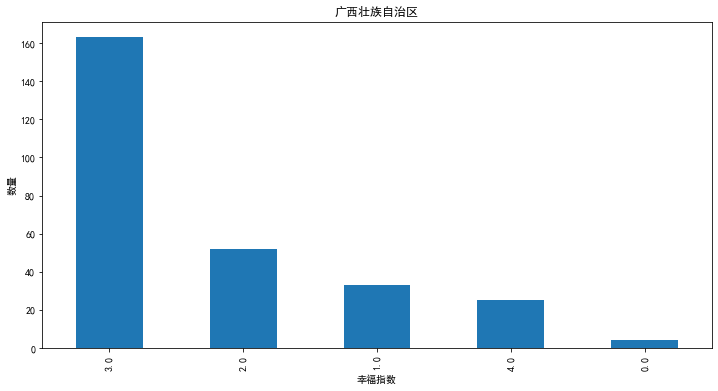

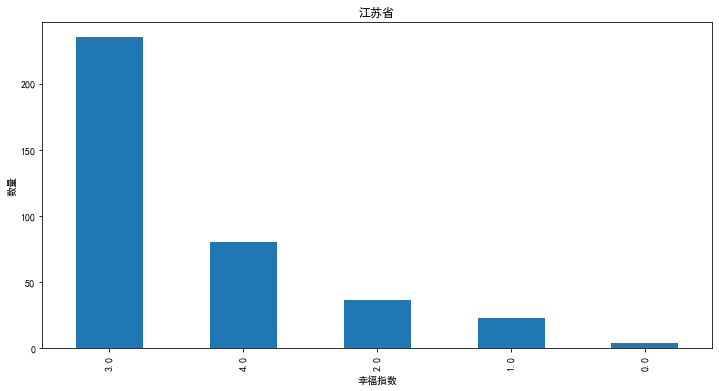

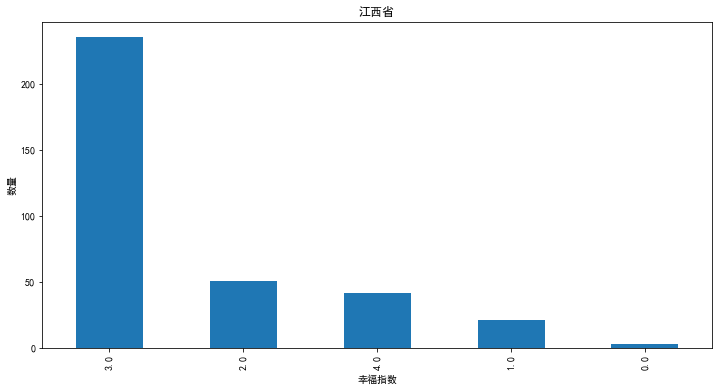

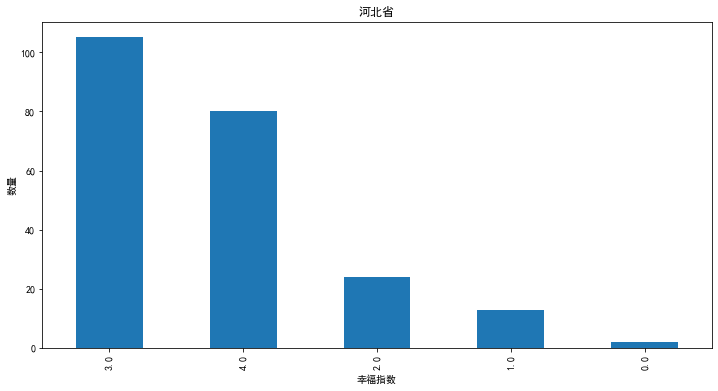

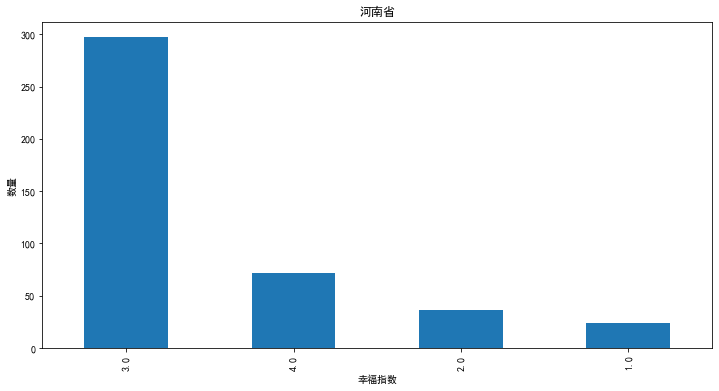

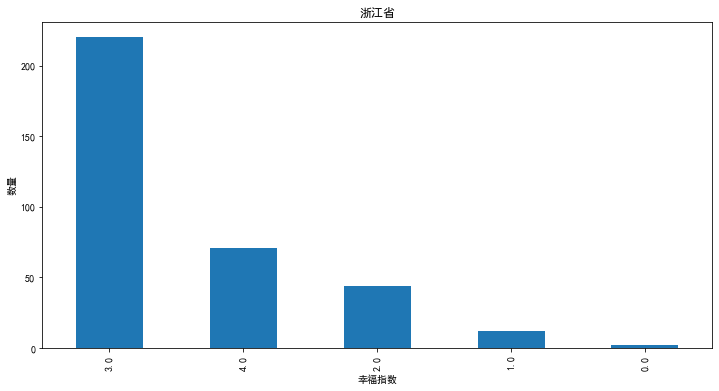

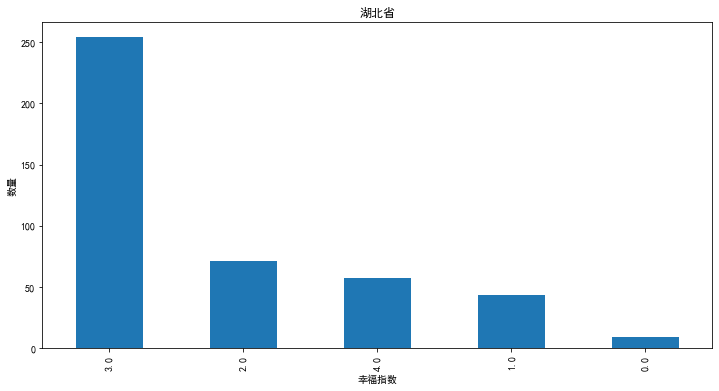

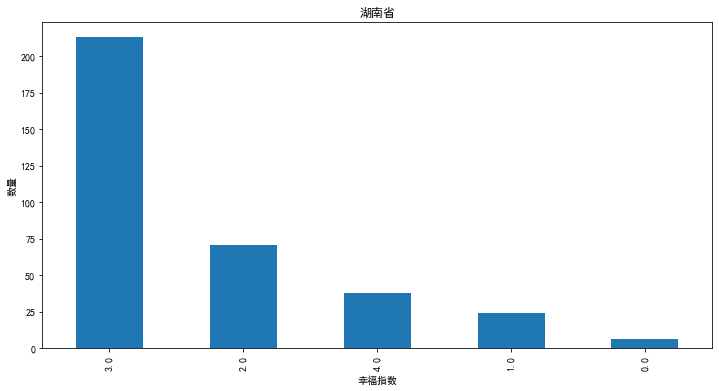

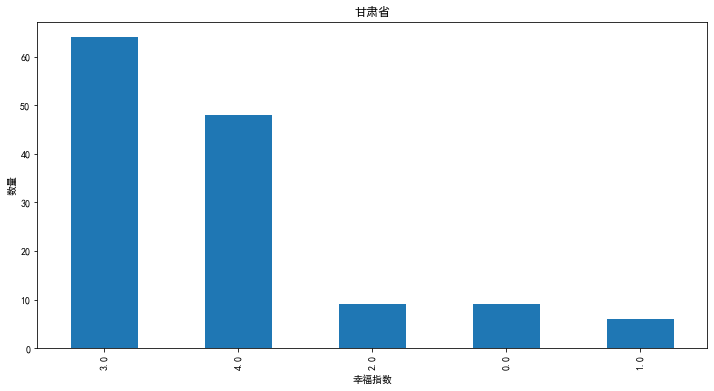

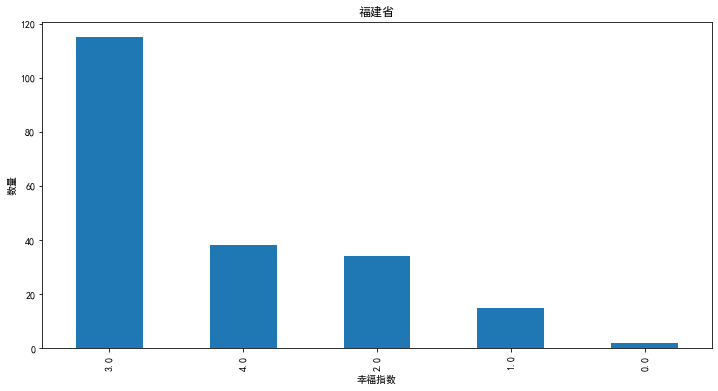

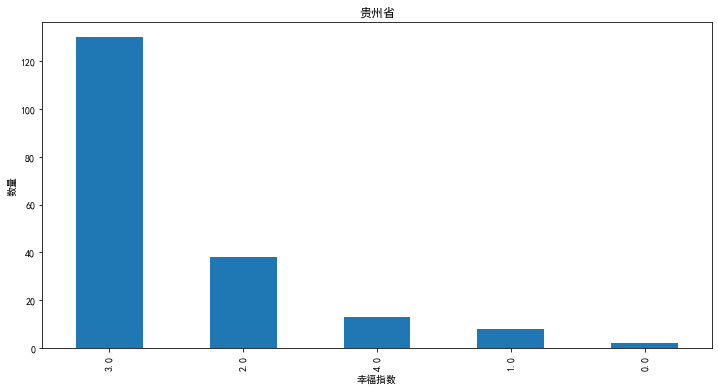

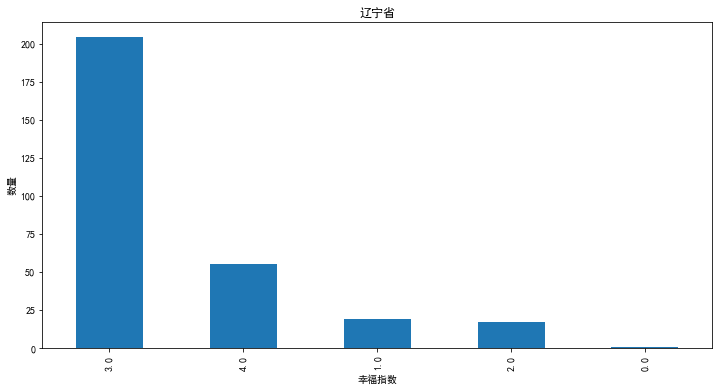

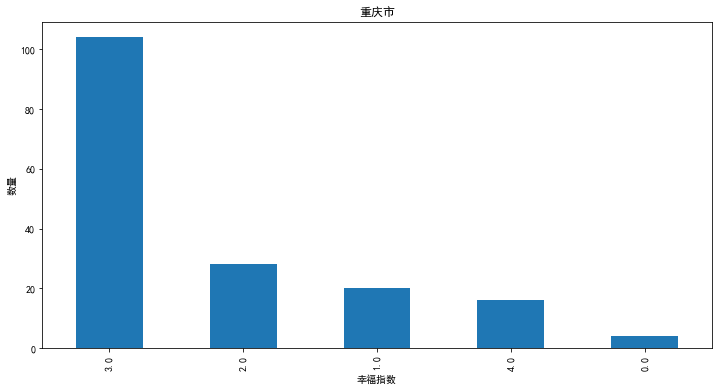

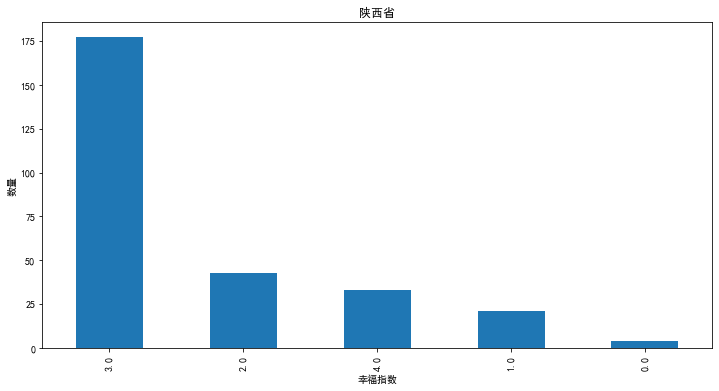

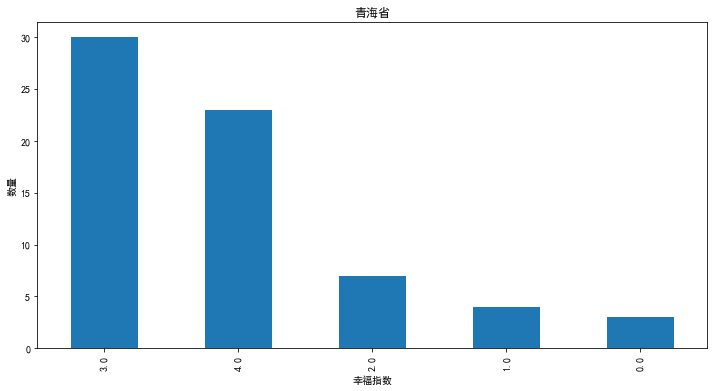

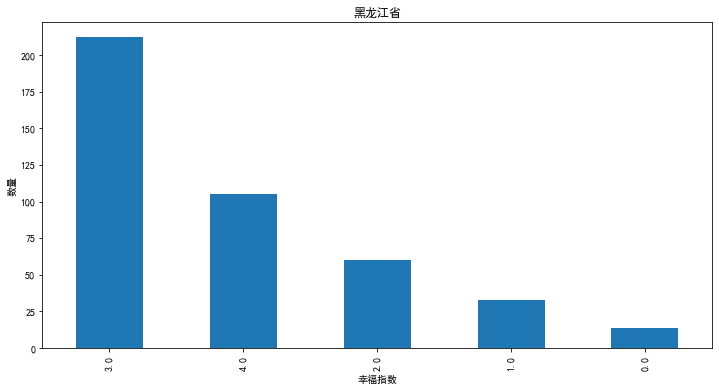

In [30]:
i=1
for k in sorted(pro):
    plt.figure(figsize=(12,6))
    data_show[data_show['province']==k].happiness.value_counts().plot.bar()
    plt.title(dict_pro[k])
    plt.xlabel('幸福指数')
    plt.ylabel('数量')
    i+=1
plt.show()

## <font color='gray' size=4> 4.4 年龄和幸福感的关系

Text(0, 0.5, 'happiness')

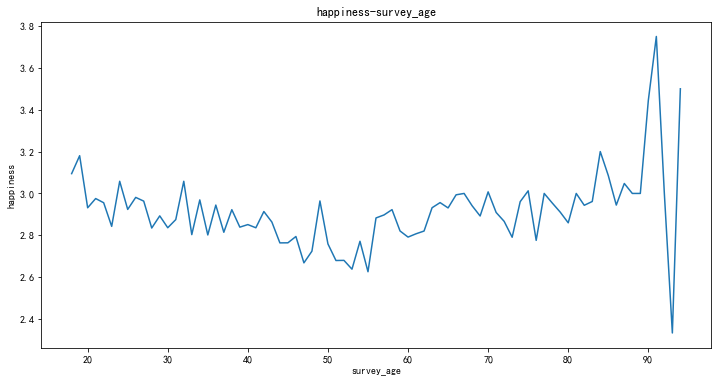

In [31]:
# 探究年龄和幸福感的关系
h_age = data_show.groupby('survey_age',as_index=False).happiness.mean()
plt.figure(figsize=(12,6))
plt.plot(h_age['survey_age'],h_age['happiness'])
plt.title('happiness-survey_age')
plt.xlabel('survey_age')
plt.ylabel('happiness')

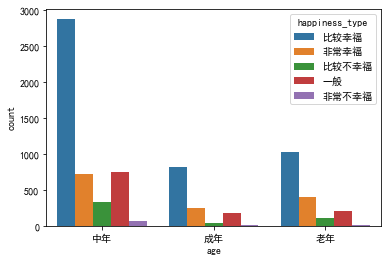

In [36]:
# 便于观察，将年龄分组
def split(x):
    if x<18:
        return '少年'
    elif 18<=x<32:
        return '成年'
    elif 32<=x<64:
        return '中年'
    elif 64<x:
        return '老年'
    
data_show['age'] = data_show['survey_age'].map(split)
sns.countplot('age',hue='happiness_type',data = data_show)

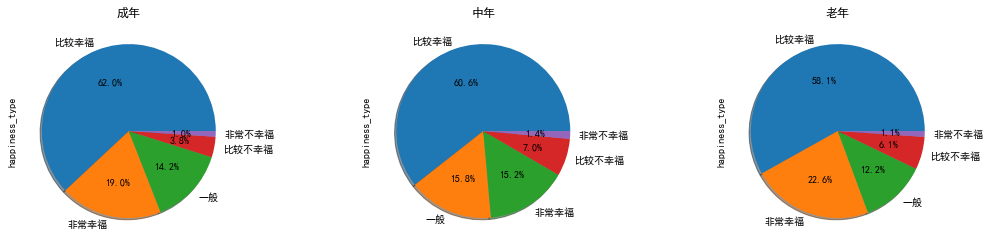

In [41]:
figure1,ax1 = plt.subplots(1,3,figsize=(18,4))
ax1[0].set_title('成年')
data_show['happiness_type'][data_show['age']=='成年'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[0],shadow=True)
ax1[1].set_title('中年')
data_show['happiness_type'][data_show['age']=='中年'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[1],shadow=True)
ax1[2].set_title('老年')
data_show['happiness_type'][data_show['age']=='老年'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax1[2],shadow=True)

## <font color='gray' size=4> 4.5 特征相关性

In [42]:
data_show.corr().happiness.sort_values(ascending=False)

happiness               1.000000
depression              0.302864
class                   0.251743
health                  0.249396
equity                  0.230912
family_status           0.204681
health_problem          0.186461
class_10_after          0.173760
public_service_6        0.163416
public_service_7        0.154780
public_service_5        0.137236
public_service_3        0.135707
public_service_9        0.130976
public_service_4        0.130837
class_10_before         0.130390
public_service_8        0.129437
public_service_2        0.127819
s_edu                   0.120748
relax                   0.114654
public_service_1        0.113742
learn                   0.109075
trust_5                 0.104284
edu                     0.103831
media_4                 0.100077
media_1                 0.095717
media_3                 0.092074
class_14                0.091371
house                   0.090884
media_2                 0.086351
weight_jin              0.085688
socialize 

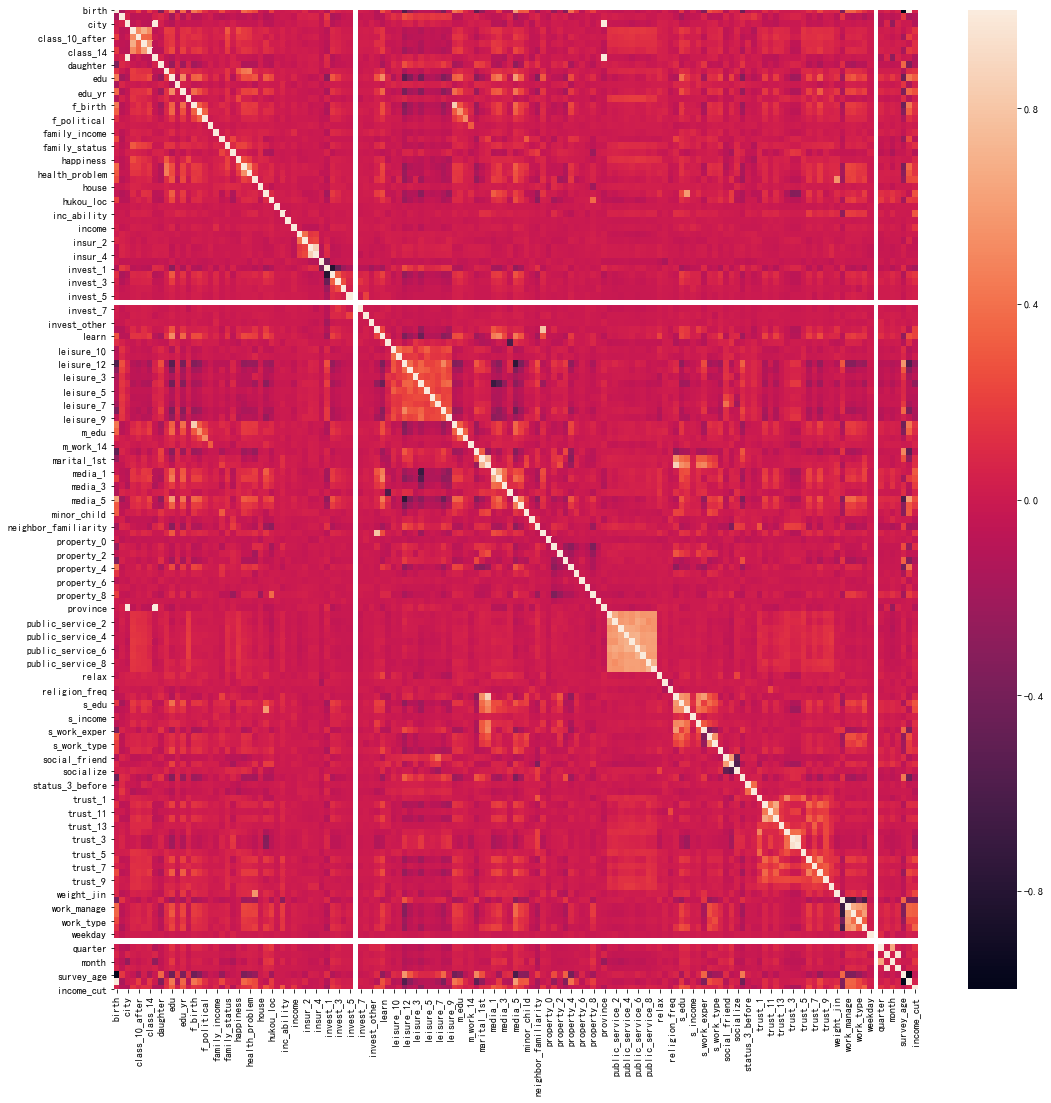

In [43]:
plt.figure(figsize=(18,18))
sns.heatmap(data_show.corr())

我们可以看出，有一部分的特征与标签的相关性较低，这一部分特征可以尝试剔除，鉴于本项目数据特征较少，我们全部保留。

# <font color='blue' size=5> 五、选择模型

In [44]:
#删除无用特征
data=data.drop(['id','happiness','survey_time'], axis=1)

In [45]:
#提取训练集和测试集
X_train_ = data[:train.shape[0]]
X_test_  = data[train.shape[0]:]
target_column = 'happiness'
feature_columns=list(X_test_.columns) 
print('训练集大小：',X_train_.shape)
print('测试集大小：',X_test_.shape)
print('特征列表：',feature_columns)

训练集大小： (8000, 145)
测试集大小： (2968, 145)
特征列表： ['birth', 'car', 'city', 'class', 'class_10_after', 'class_10_before', 'class_14', 'county', 'daughter', 'depression', 'edu', 'edu_status', 'edu_yr', 'equity', 'f_birth', 'f_edu', 'f_political', 'f_work_14', 'family_income', 'family_m', 'family_status', 'floor_area', 'gender', 'health', 'health_problem', 'height_cm', 'house', 'hukou', 'hukou_loc', 'inc_ability', 'inc_exp', 'income', 'insur_1', 'insur_2', 'insur_3', 'insur_4', 'invest_0', 'invest_1', 'invest_2', 'invest_3', 'invest_4', 'invest_5', 'invest_6', 'invest_7', 'invest_8', 'invest_other', 'join_party', 'learn', 'leisure_1', 'leisure_10', 'leisure_11', 'leisure_12', 'leisure_2', 'leisure_3', 'leisure_4', 'leisure_5', 'leisure_6', 'leisure_7', 'leisure_8', 'leisure_9', 'm_birth', 'm_edu', 'm_political', 'm_work_14', 'marital', 'marital_1st', 'marital_now', 'media_1', 'media_2', 'media_3', 'media_4', 'media_5', 'media_6', 'minor_child', 'nationality', 'neighbor_familiarity', 'political'

In [46]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

## <font color='gray' size=4> 5.1 XGB

### <font color='gray' size=3> 5.1.1 训练模型

In [47]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

In [48]:
##### xgb
xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 4, 'subsample': 0.7,'alpha':1,'lambda':1,
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2020)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf_xgb = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf_xgb.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf_xgb.best_ntree_limit)
    predictions_xgb += clf_xgb.predict(xgb.DMatrix(X_test), ntree_limit=clf_xgb.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[0]	train-rmse:2.48921	valid_data-rmse:2.50734	train-myFeval:6.19618	valid_data-myFeval:6.28677
Multiple eval metrics have been passed: 'valid_data-myFeval' will be used for early stopping.

Will train until valid_data-myFeval hasn't improved in 200 rounds.
[100]	train-rmse:1.61381	valid_data-rmse:1.63826	train-myFeval:2.60439	valid_data-myFeval:2.6839
[200]	train-rmse:1.12375	valid_data-rmse:1.15458	train-myFeval:1.26282	valid_data-myFeval:1.33305
[300]	train-rmse:0.869031	valid_data-rmse:0.905285	train-myFeval:0.755215	valid_data-myFeval:0.819541
[400]	train-rmse:0.74649	valid_data-rmse:0.787495	train-myFeval:0.557247	valid_data-myFeval:0.620148
[500]	train-rmse:0.689585	valid_data-rmse:0.734863	train-myFeval:0.475527	valid_data-myFeval:0.540024
[600]	train-rmse:0.661643	valid_data-rmse:0.710956	train-myFeval:0.437772	valid_data-myFeval:0.505459
[700]	train-rmse:0.645936	valid_data-rmse:0.699257	train-myFeval:0.417233	valid_data-myFeval:0.488961
[800]	train-rmse:0.63538	vali

[200]	train-rmse:1.12736	valid_data-rmse:1.1375	train-myFeval:1.27094	valid_data-myFeval:1.29392
[300]	train-rmse:0.87296	valid_data-rmse:0.886314	train-myFeval:0.76206	valid_data-myFeval:0.785552
[400]	train-rmse:0.750146	valid_data-rmse:0.766976	train-myFeval:0.56272	valid_data-myFeval:0.588253
[500]	train-rmse:0.69274	valid_data-rmse:0.714002	train-myFeval:0.479889	valid_data-myFeval:0.509799
[600]	train-rmse:0.664411	valid_data-rmse:0.69067	train-myFeval:0.441442	valid_data-myFeval:0.477024
[700]	train-rmse:0.648228	valid_data-rmse:0.679329	train-myFeval:0.4202	valid_data-myFeval:0.461487
[800]	train-rmse:0.637076	valid_data-rmse:0.673509	train-myFeval:0.405866	valid_data-myFeval:0.453615
[900]	train-rmse:0.628432	valid_data-rmse:0.670344	train-myFeval:0.394927	valid_data-myFeval:0.449361
[1000]	train-rmse:0.62115	valid_data-rmse:0.66822	train-myFeval:0.385828	valid_data-myFeval:0.446518
[1100]	train-rmse:0.614413	valid_data-rmse:0.667068	train-myFeval:0.377503	valid_data-myFeval:0

[2400]	train-rmse:0.552893	valid_data-rmse:0.68519	train-myFeval:0.30569	valid_data-myFeval:0.469485
[2500]	train-rmse:0.549124	valid_data-rmse:0.685186	train-myFeval:0.301538	valid_data-myFeval:0.46948
[2600]	train-rmse:0.545578	valid_data-rmse:0.684903	train-myFeval:0.297655	valid_data-myFeval:0.469093
[2700]	train-rmse:0.541956	valid_data-rmse:0.684745	train-myFeval:0.293716	valid_data-myFeval:0.468876
[2800]	train-rmse:0.53837	valid_data-rmse:0.684768	train-myFeval:0.289843	valid_data-myFeval:0.468907
[2900]	train-rmse:0.534686	valid_data-rmse:0.684784	train-myFeval:0.285889	valid_data-myFeval:0.46893
Stopping. Best iteration:
[2776]	train-rmse:0.539244	valid_data-rmse:0.684703	train-myFeval:0.290784	valid_data-myFeval:0.468818

CV score: 0.45703022


In [49]:
result=list(predictions_xgb)
result=list(map(lambda x: x + 1, result))

test_sub['happiness']=result
test_sub.to_csv('submit_xgb.csv', index=False)

### <font color='gray' size=3> 5.1.2 XGB特征重要性

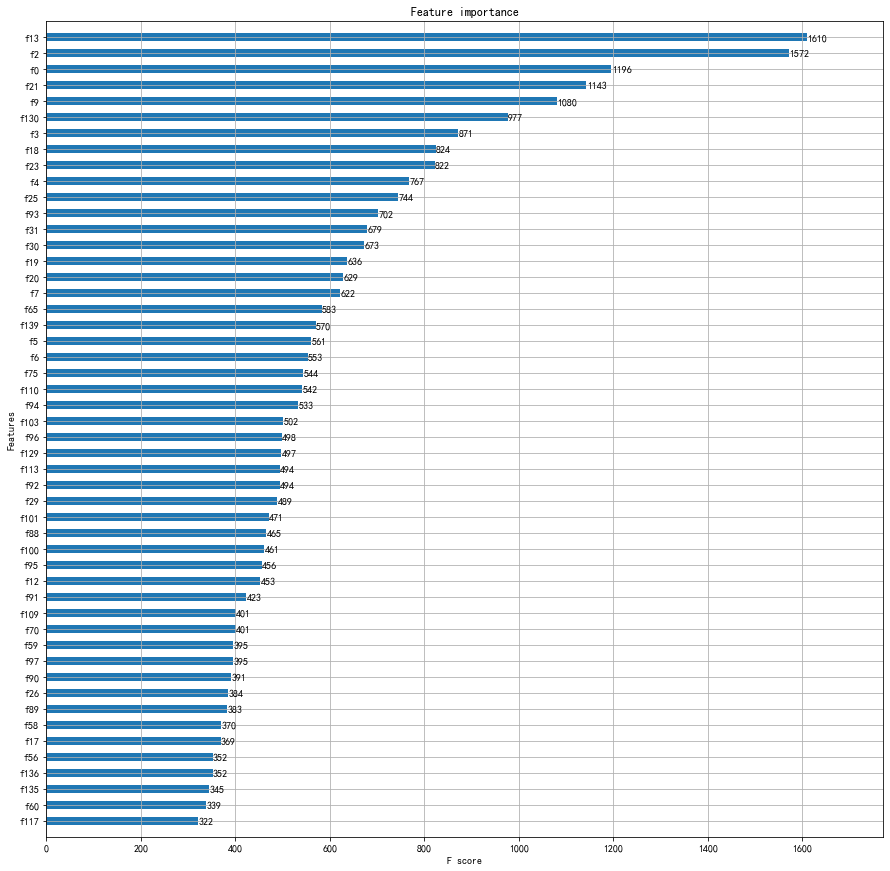

In [50]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(clf_xgb,
                height=0.5,
                ax=ax,
                max_num_features=50)
plt.show()

## <font color='gray' size=4> 5.2 LGB

<font color='gray' size=3> 5.2.1 训练模型

In [51]:
##### lgb
param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 40,
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2020)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])  
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])
    num_round = 10000
    clf_lgb = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf_lgb.predict(X_train[val_idx], num_iteration=clf_lgb.best_iteration)   
    predictions_lgb += clf_lgb.predict(X_test, num_iteration=clf_lgb.best_iteration) / folds.n_splits
print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))

fold n°1
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.43746	valid_1's l2: 0.496635
[400]	training's l2: 0.375607	valid_1's l2: 0.469734
[600]	training's l2: 0.336699	valid_1's l2: 0.459974
[800]	training's l2: 0.307571	valid_1's l2: 0.455134
[1000]	training's l2: 0.283332	valid_1's l2: 0.45426
[1200]	training's l2: 0.261958	valid_1's l2: 0.45391
[1400]	training's l2: 0.243403	valid_1's l2: 0.453389
Early stopping, best iteration is:
[1351]	training's l2: 0.247539	valid_1's l2: 0.452979
fold n°2
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.433033	valid_1's l2: 0.505318
[400]	training's l2: 0.370343	valid_1's l2: 0.478511
[600]	training's l2: 0.331913	valid_1's l2: 0.471573
[800]	training's l2: 0.30275	valid_1's l2: 0.469428
[1000]	training's l2: 0.278466	valid_1's l2: 0.46913
[1200]	training's l2: 0.257429	valid_1's l2: 0.468991
Early stopping, best iteration is:
[1164]	training's l2: 0.261063	valid_1's l2: 

In [52]:
result=list(predictions_lgb)
result=list(map(lambda x: x + 1, result))

test_sub['happiness']=result
test_sub.to_csv('submit_lgb.csv', index=False)

<font color='gray' size=3> 5.2.2 LGB特征重要性

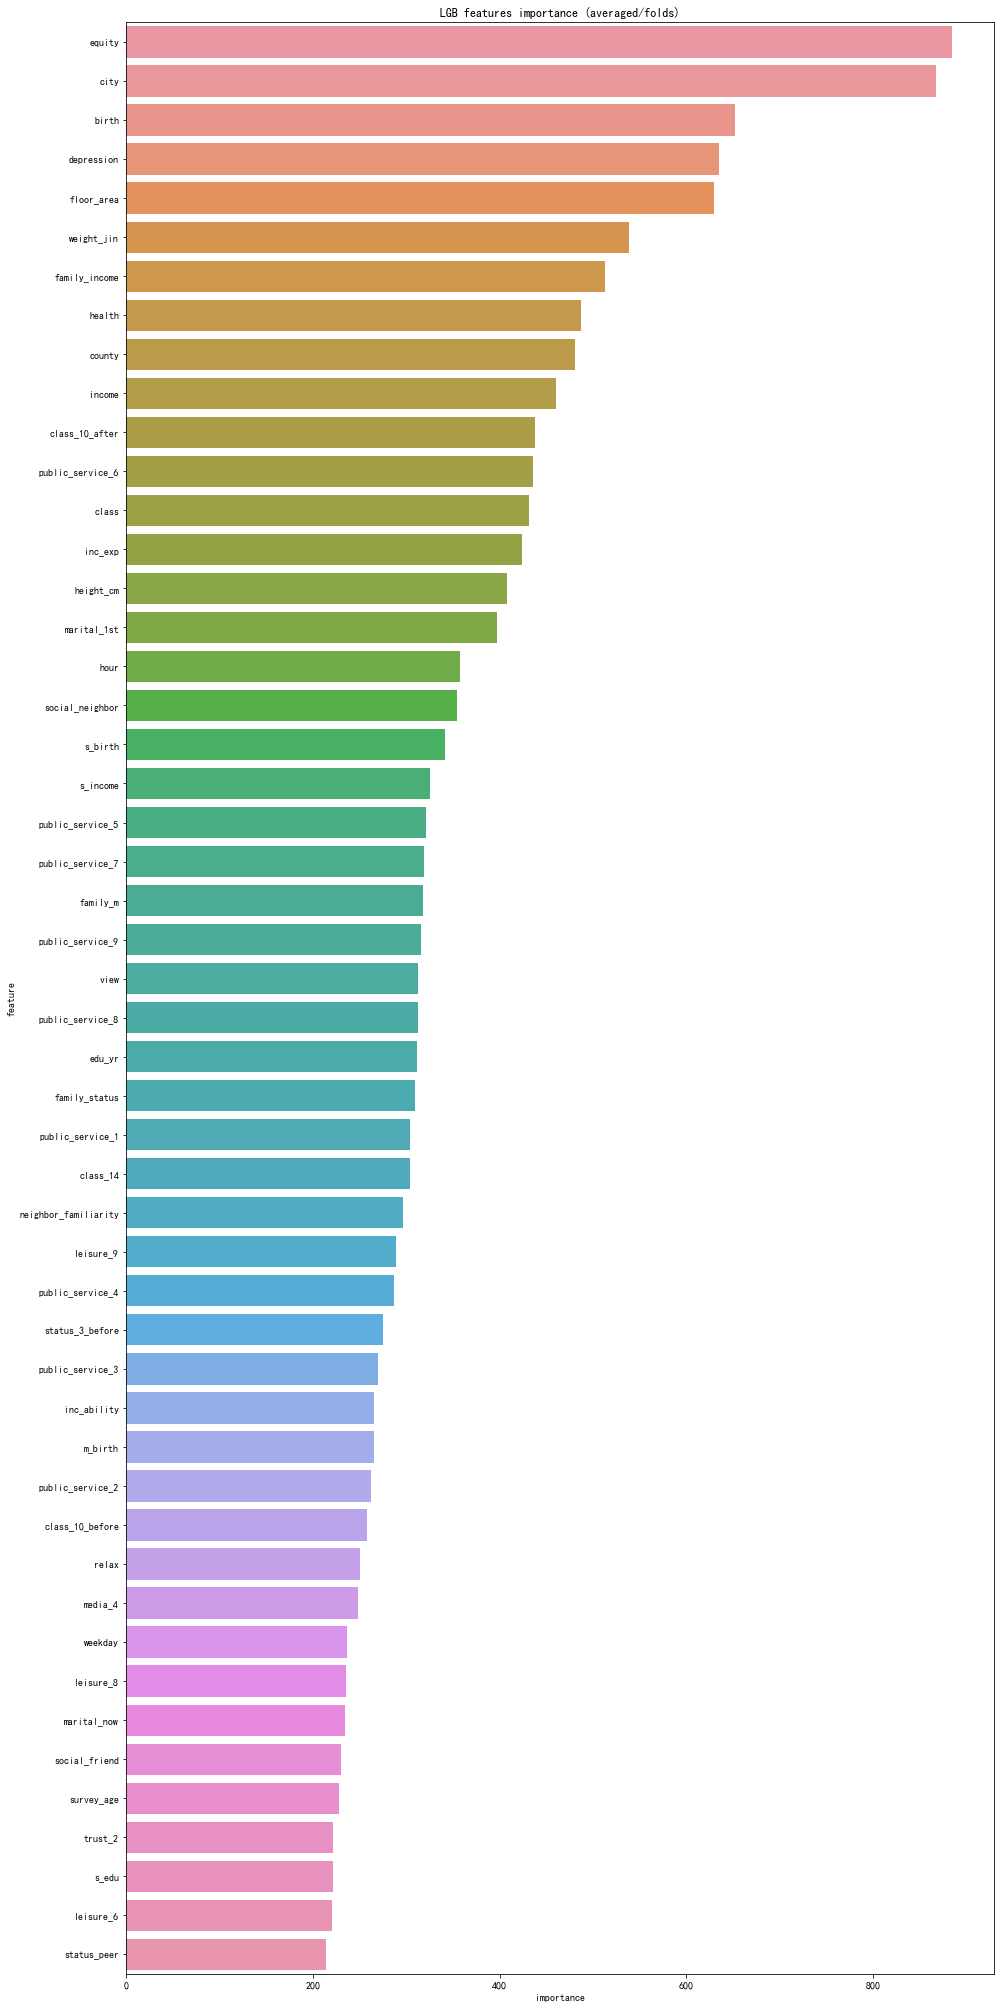

In [53]:
df = pd.DataFrame(X_test_.columns.tolist(), columns=['feature'])
df['importance']=list(clf_lgb.feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('LGB features importance (averaged/folds)')
plt.tight_layout()

## <font color='gray' size=4> 5.3 CAT

<font color='gray' size=3> 5.3.1 训练模型

In [54]:
kfolder = KFold(n_splits=5, shuffle=True, random_state=2020)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits
print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))

fold n°0
0:	learn: 0.8094790	test: 0.8152764	best: 0.8152764 (0)	total: 77.4ms	remaining: 2h 9m 1s
100:	learn: 0.6680843	test: 0.6949257	best: 0.6949257 (100)	total: 584ms	remaining: 9m 37s
200:	learn: 0.6382564	test: 0.6811796	best: 0.6811549 (198)	total: 1.09s	remaining: 9m 3s
300:	learn: 0.6111041	test: 0.6774602	best: 0.6774476 (298)	total: 1.57s	remaining: 8m 39s
400:	learn: 0.5884050	test: 0.6765241	best: 0.6763594 (360)	total: 2.06s	remaining: 8m 32s
500:	learn: 0.5675499	test: 0.6743594	best: 0.6743362 (499)	total: 2.54s	remaining: 8m 23s
600:	learn: 0.5493112	test: 0.6725010	best: 0.6725010 (600)	total: 3.04s	remaining: 8m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721643787
bestIteration = 614

Shrink model to first 615 iterations.
fold n°1
0:	learn: 0.8053835	test: 0.8319370	best: 0.8319370 (0)	total: 5.42ms	remaining: 9m 2s
100:	learn: 0.6637956	test: 0.7054222	best: 0.7054222 (100)	total: 527ms	remaining: 8m 40s
200:	learn: 0.6335377	test: 0.6

In [55]:
result=list(predictions_cb)
result=list(map(lambda x: x + 1, result))
test_sub['happiness']=result
test_sub.to_csv('submit_cb.csv', index=False)

<font color='gray' size=3> 5.3.2 CAT特征重要性

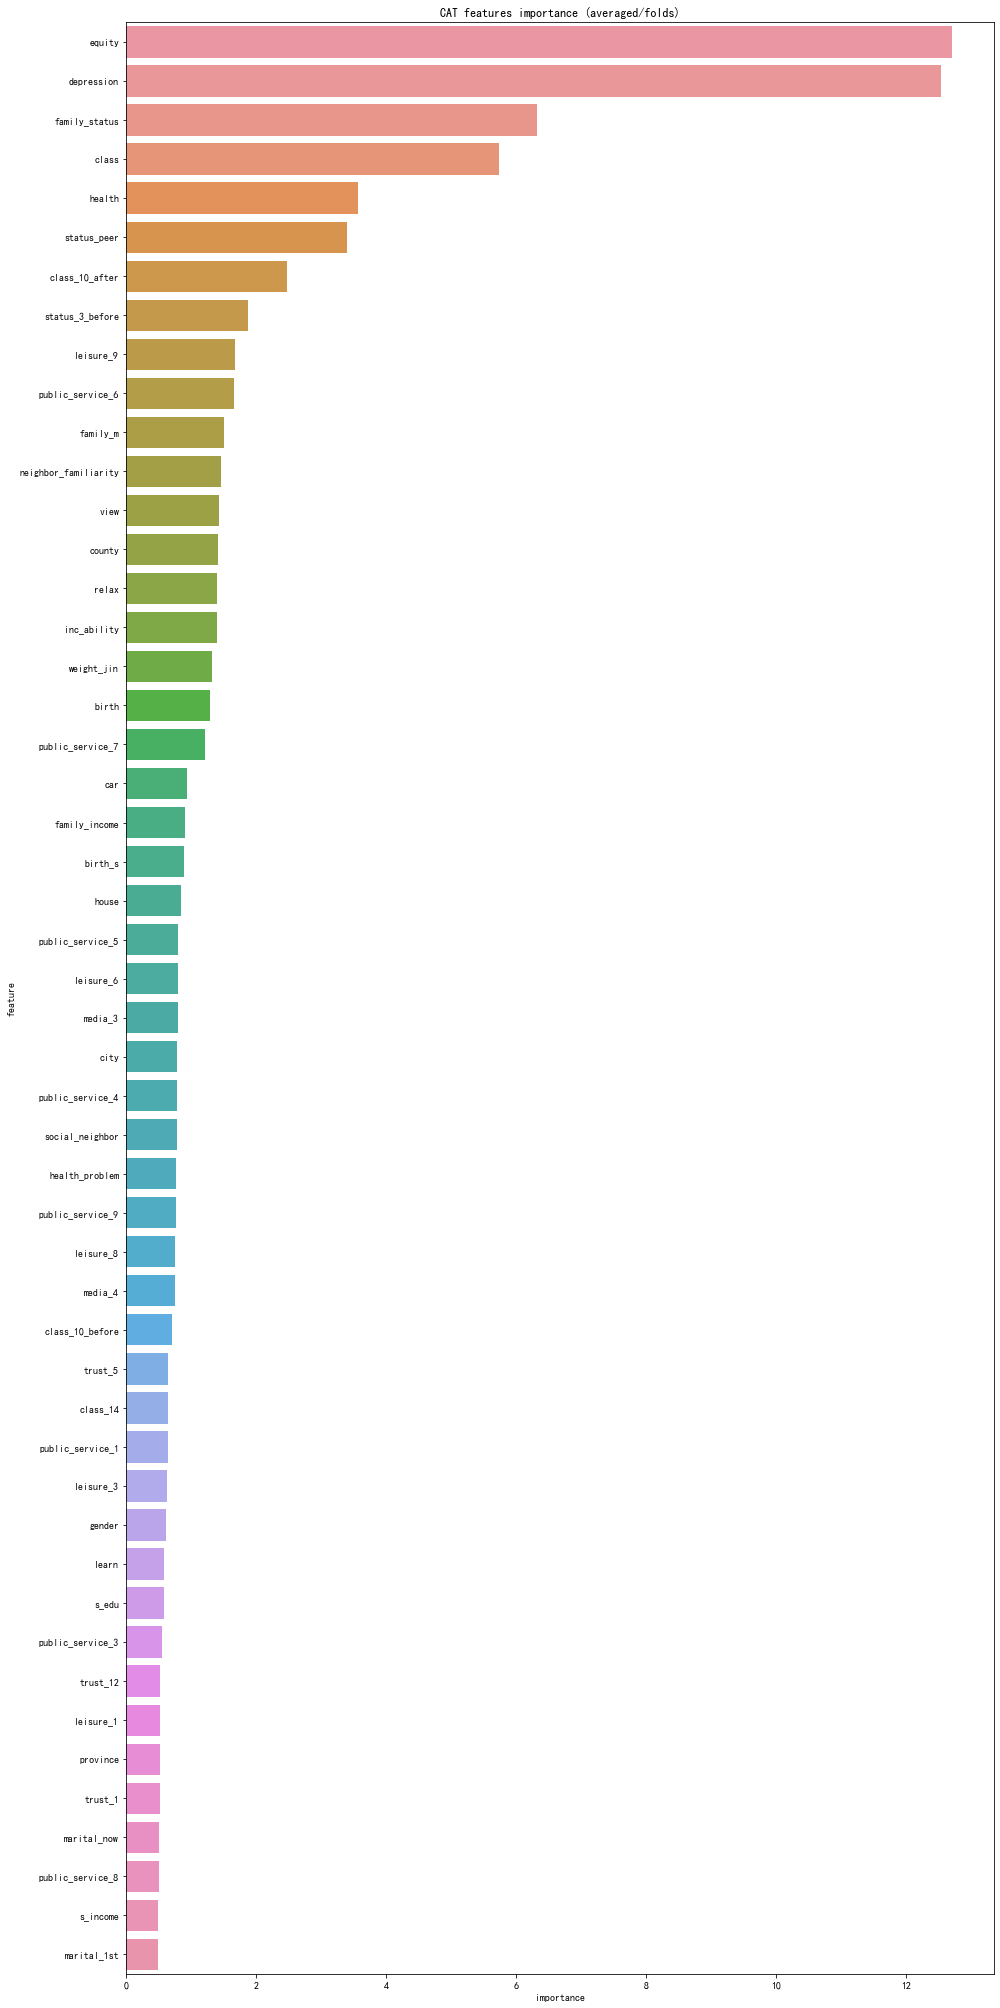

In [56]:
df = pd.DataFrame(X_test_.columns.tolist(), columns=['feature'])
df['importance']=list(model_cb.get_feature_importance())
df = df.sort_values(by='importance',ascending=False)
plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=df.head(50))
plt.title('CAT features importance (averaged/folds)')
plt.tight_layout()

# <font color='blue' size=5> 六、模型融合，预测结果

In [57]:
from sklearn import linear_model
from sklearn.model_selection import RepeatedKFold
# 将lgb和xgb和ctb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb,oof_cb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb,predictions_cb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])
for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    clf_3 = linear_model.BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, y_train)))


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.45598300


In [58]:
result=list(predictions)
result=list(map(lambda x: x + 1, result))

test_sub['happiness']=result
test_sub.to_csv('submit_20200129.csv', index=False)